In [1]:
import numpy as np
import matplotlib.pyplot as plt
from profit.sur.backend.gp_functions import invert, nll, predict_f, \
    get_marginal_variance_BBQ, wld_get_marginal_variance
from profit.sur.backend.kernels import kern_sqexp
from profit.util.halton import halton


In [2]:
def f(x): return x*np.cos(10*x)

# Custom function to build GP matrix
def build_K(xa, xb, hyp, K):
    for i in np.arange(len(xa)):
        for j in np.arange(len(xb)):
            K[i, j] = kern_sqexp(xa[i], xb[j], hyp[0])

noise_train = 0.01

ntrain = 15
xtrain = halton(1, ntrain)
ftrain = f(xtrain)
np.random.seed(0)
ytrain = ftrain + noise_train*np.random.randn(ntrain, 1)

In [3]:
# GP regression with fixed kernel hyperparameters
hyp = [0.1, 1e-3]  # l and sig_noise**2

K = np.empty((ntrain, ntrain))   # train-train
build_K(xtrain, xtrain, hyp, K)  # writes inside K
Ky = K + hyp[-1]*np.eye(ntrain)
Kyinv = invert(Ky, 4, 1e-6)       # using gp_functions.invert

ntest = 20
xtest = np.linspace(0, 1, ntest)
ftest = f(xtest)

Ks = np.empty((ntrain, ntest))  # train-test
Kss = np.empty((ntest, ntest))  # test-test
build_K(xtrain, xtest, hyp, Ks)
build_K(xtest, xtest, hyp, Kss)

fmean = Ks.T.dot(Kyinv.dot(ytrain)) # predictive mean


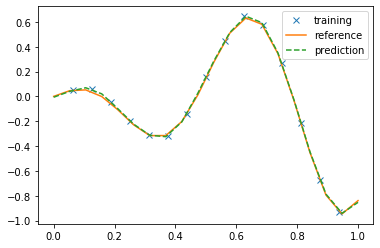

In [4]:
plt.figure()
plt.plot(xtrain, ytrain, 'x')
plt.plot(xtest, ftest, '-')
plt.plot(xtest, fmean, '--')
plt.legend(('training', 'reference', 'prediction'))

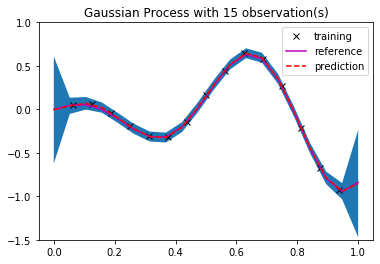

In [5]:
Ef, varf = predict_f(hyp, xtrain.reshape(-1, 1),
                      ytrain.reshape(-1, 1), xtest.reshape(-1, 1), neig=8)# posterior 
# Estimation and variance
varf = np.diag(varf)

# we keep only the diag because the variance is on it, the other terms are covariance


plt.plot(xtrain, ytrain, 'kx')
plt.plot(xtest, ftest, 'm-')
plt.plot(xtest, fmean, 'r--')
axes = plt.gca()
axes.set_ylim([-1.5, 1])
plt.title('Gaussian Process with '+ str(ntrain) + ' observation(s)')
plt.legend(('training', 'reference', 'prediction'))



plt.fill_between(xtest, # x
                 (fmean.flatten() + 2 * np.sqrt(varf)), # y1
                 (fmean.flatten() - 2 * np.sqrt(varf))) # y2

In [6]:
# Negative log likelihood over length scale
ls = np.linspace(1e-3, 3, 50)
nlls = np.array(
    [nll([l, 0.00694534], xtrain, ytrain, 0) for l in ls]
    ).flatten()

Text(0.5, 1.0, 'Negative log-likelihood')

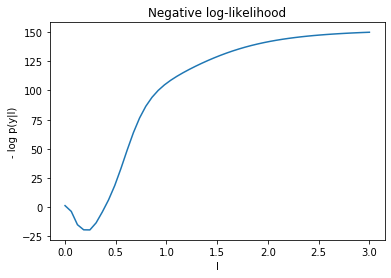

In [7]:
plt.figure()
plt.plot(ls, nlls)
plt.xlabel('l')
plt.ylabel('- log p(y|l)')
plt.title('Negative log-likelihood')

In [8]:
from scipy.optimize import minimize

def nll_transform(log10hyp):
    hyp = 10**log10hyp
    return nll(hyp, xtrain, ytrain, 0)

res = minimize(nll_transform, np.array([0, -6]), method='BFGS')

In [9]:
print(res)
#hyp = 10**res.x
print('[l,sig2] = ', 10**res.x)
print('[log_l, log_s2] = ', res.x)
log_l = res.x[0]
log_s2= res.x[1]
log_hyp = [log_l, log_s2]

new_hyp = [10**res.x[0], 10**res.x[1]]
hess_inv = res.hess_inv
print("\nhess_inv = ", hess_inv)
print("\nhess = ", invert(hess_inv))

      fun: -33.19243446725801
 hess_inv: array([[0.00258257, 0.00293283],
       [0.00293283, 0.00333659]])
      jac: array([-1.15394592e-04,  1.71661377e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 586
      nit: 34
     njev: 144
   status: 2
  success: False
        x: array([-0.6501623 , -4.15975645])
[l,sig2] =  [2.23788466e-01 6.92219056e-05]
[log_l, log_s2] =  [-0.6501623  -4.15975645]

hess_inv =  [[0.00258257 0.00293283]
 [0.00293283 0.00333659]]

hess =  [[ 215019.63731611 -189000.00222227]
 [-189000.00222227  166428.72359908]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


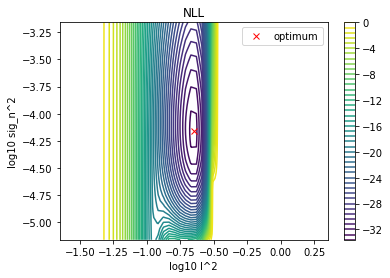

In [10]:
nl = 50
ns2 = 40

log10l = np.linspace(res.x[0]-1, res.x[0]+1, nl)
log10s2 = np.linspace(res.x[1]-1, res.x[1]+1, ns2)
[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nll([10**ll, 10**ls2], xtrain, ytrain, 0) for ls2 in log10s2 for ll in log10l]
    ).reshape([ns2, nl])
    
# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL')
plt.contour(Ll, Ls2, nlls, levels=50)
plt.plot(res.x[0], res.x[1], 'rx')
plt.xlabel('log10 l^2')
plt.ylabel('log10 sig_n^2')
plt.colorbar()
plt.legend(['optimum'])
plt.show()

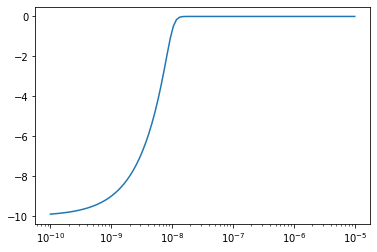

In [11]:
# Trying out priors to cut values

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def prior(hyp):
    return sigmoid(hyp[0]-6)*sigmoid(hyp[-1]-6)

x = np.logspace(-10, -5, 100)
plt.semilogx(x, np.log(sigmoid(1e9*x - 10)))

In [12]:
from profit.sur.backend.gp_functions import k

def dk_logdl(xa, xb, l): # derivative of the kernel w.r.t log lengthscale
    dk_dl = ((xa - xb)**2.0 * np.exp(-(xa-xb)**2.0/(2 * l**2))) / l**3 
    dk_logdl = dk_dl * np.log(10) * 10**log_l # from log lengthscale to lengthscale
    return dk_logdl
    

def dkdl(xa, xb, l): # derivative of the kernel w.r.t lengthscale
    dk_dl = ((xa - xb)**2.0 * np.exp(-(xa-xb)**2.0/(2 * l**2))) / l**3 
    return dk_dl

In [13]:

log_K = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    
    for j in np.arange(len(xtrain)):
        log_K[i, j] = k(xtrain[i], xtrain[j], log_hyp[0])


log_K_star = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        log_K_star[i, j] = k(xtest[i], xtrain[j], log_hyp[0])


log_K_prime = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        log_K_prime[i, j] = dk_logdl(xtrain[i], xtrain[j], log_hyp[0])


log_K_star_prime = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        log_K_star_prime[i, j] = dk_logdl(xtest[i], xtrain[j], log_hyp[0])




# K.shape = (20, 20)
# K_prime.shape = (20, 20)

# K_star.shape = (10, 20)
# K_star_prime.shape = (10, 20)

In [14]:


log_Ky = log_K + log_hyp[-1]*np.eye(ntrain)
log_Kyinv = invert(log_Ky, 4, 1e-6)

alpha = np.dot(Kyinv, ytrain) # RW p17 paragraph 4

log_dalpha_dl = -Kyinv.dot(log_K_prime)\
    .dot(Kyinv)\
    .dot(ytrain)

log_dalpha_ds = -Kyinv.dot(np.log(10) * 10**log_s2 * np.eye(ntrain)).dot(Kyinv).dot(ytrain) # - Kyinv x ln(10) x 10^log_sigma x I x Kyinv x ytrain 

log_dm = np.empty((ntest,len(hyp), 1))

for nb_hyp in range(len(hyp)):
    if nb_hyp == 0 :
        log_dm[:,nb_hyp,:] = np.dot(log_K_star_prime, alpha) -\
                         np.dot(log_K_star, log_dalpha_dl) 
    else : 
        log_dm[:,nb_hyp,:] = np.dot(log_K_star, log_dalpha_ds)

print("\n\n\ndm :",log_dm.shape, "\n\n")
#print(dm)

    




LinAlgError: Matrix is not positive definite

In [15]:
log_sigma = invert(hess_inv) # define the sigma matrix as the inverse of hess_inv
V = varf # set V as the result of the predict_f diagonal  

#print("\nsigma shape : ", log_sigma.shape)
#print(log_sigma)
#print("dm.shape : ", log_dm.shape)


log_dm_transpose = np.empty((ntest, 1, len(log_hyp)))
log_dmT_dot_sigma = np.empty((ntest, 1, len(log_hyp)))
log_dmT_dot_sigma_dot_dm = np.empty((ntest, 1))



for i in range(ntest):
    log_dm_transpose[i] = log_dm[i].T
    #print("\n\ndm.t",i,' : ', log_dm_transpose[i])
    log_dmT_dot_sigma[i] = log_dm_transpose[i].dot(log_sigma)
    #print("sigma = ", log_sigma)
    #print("dmT_dot_sigma",i," : ", log_dmT_dot_sigma[i])
    log_dmT_dot_sigma_dot_dm[i] = log_dmT_dot_sigma[i].dot(log_dm[i])
    #print("dmT_dot_sigma_dot_dm",i," : ", dmT_dot_sigma_dot_dm[i])
    
# print("dm_transpose :", dm_transpose.shape)
# print("\ndmT_dot_sigma ", dmT_dot_sigma.shape)
# print("dmT_dot_sigma_dot_dm ", dmT_dot_sigma_dot_dm.shape)
# print("V ", V.shape)


 
log_V_tild = V.reshape((ntest,1)) + log_dmT_dot_sigma_dot_dm # Osborne et al. (2012) Active learning eq.19 


print("V_tild.shape ", log_V_tild.shape)
print("\n\n\tMarginal variance\n\n", log_V_tild )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


NameError: name 'log_dm' is not defined

In [16]:
import time

tac = time.time()
marginal_variance = get_marginal_variance_BBQ(hess_inv, new_hyp, ntrain, ntest, xtrain, xtest, 
                                          Kyinv, ytrain, varf, True)
tuc = time.time()

log_time = tuc - tac 
print(log_time, " second\n-> ", log_time * 1000, " ms")


time consumed :  0.9889602661132812  ms

The marginal Variance has a shape of  (20, 1)


	Marginal variance

 [[0.0951895 ]
 [0.00221712]
 [0.0013399 ]
 [0.00141255]
 [0.0023131 ]
 [0.00298984]
 [0.00243473]
 [0.00105946]
 [0.00148805]
 [0.00718262]
 [0.01895503]
 [0.03247808]
 [0.04016598]
 [0.03687722]
 [0.02445723]
 [0.01048757]
 [0.00225327]
 [0.00154823]
 [0.00460224]
 [0.09844374]]
0.0279848575592041  second
->  27.9848575592041  ms


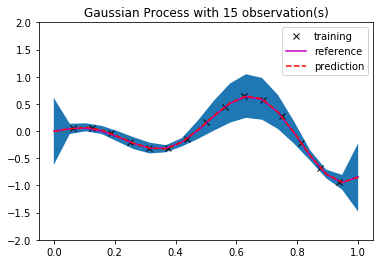

In [17]:

plt.plot(xtrain, ytrain, 'kx')
plt.plot(xtest, ftest, 'm-')
plt.plot(xtest, fmean, 'r--')
axes = plt.gca()
axes.set_ylim([-2, 2])
plt.title('Gaussian Process with '+ str(ntrain) + ' observation(s)')
plt.legend(('training', 'reference', 'prediction'))



plt.fill_between(xtest, # x
                 (fmean.flatten() + 2 * np.sqrt(marginal_variance.flatten())), # y1
                 (fmean.flatten() - 2 * np.sqrt(marginal_variance.flatten()))) # y2


In [18]:
def wld_get_marginal_variance(wld_hess_inv, wld_hyp, ntrain, ntest, xtrain, xtest,
                              Kyinv, ytrain, varf, plot_result = False):



    ######################### Build needed Kernel Matrix #########################
    wld_K = np.empty((ntrain, ntrain))
    for i in np.arange(len(xtrain)):
        for j in np.arange(len(xtrain)):
            wld_K[i, j] = k(xtrain[i], xtrain[j], wld_hyp[0])


    wld_K_star = np.empty((ntest, ntrain))
    for i in np.arange(len(xtest)):
        for j in np.arange(len(xtrain)):
            wld_K_star[i, j] = k(xtest[i], xtrain[j], wld_hyp[0])


    wld_K_prime = np.empty((ntrain, ntrain))
    for i in np.arange(len(xtrain)):
        for j in np.arange(len(xtrain)):
            wld_K_prime[i, j] = dkdl(xtrain[i], xtrain[j], wld_hyp[0])


    wld_K_star_prime = np.empty((ntest, ntrain))
    for i in np.arange(len(xtest)):
        for j in np.arange(len(xtrain)):
            wld_K_star_prime[i, j] = dkdl(xtest[i], xtrain[j], wld_hyp[0])
    ############################################################################


    wld_alpha = np.dot(Kyinv, ytrain) # RW p17 paragraph 4

    wld_dalpha_dl = -Kyinv.dot(wld_K_prime)\
        .dot(Kyinv)\
        .dot(ytrain)

    wld_dalpha_ds = -Kyinv.dot(np.eye(ntrain)).dot(Kyinv).dot(ytrain) # - Kyinv x I x Kyinv x ytrain

    wld_dm = np.empty((ntest,len(wld_hyp), 1))


    for nb_hyp in range(len(wld_hyp)):
        if nb_hyp == 0 :
            wld_dm[:,nb_hyp,:] = np.dot(wld_K_star_prime, wld_alpha) -\
                             np.dot(wld_K_star, wld_dalpha_dl)
        else :
            wld_dm[:,nb_hyp,:] = np.dot(wld_K_star, wld_dalpha_ds)

    V = varf # set V as the result of the predict_f diagonal
    wld_sigma = invert(wld_hess_inv)
    print("sigma ", wld_sigma)

    wld_dm_transpose = np.empty((ntest, 1, len(wld_hyp)))
    wld_dmT_dot_sigma = np.empty((ntest, 1, len(wld_hyp)))
    wld_dmT_dot_sigma_dot_dm = np.empty((ntest, 1))

    for i in range(ntest):
        wld_dm_transpose[i] = wld_dm[i].T
        wld_dmT_dot_sigma[i] = wld_dm_transpose[i].dot(wld_sigma)
        wld_dmT_dot_sigma_dot_dm[i] = wld_dmT_dot_sigma[i].dot(wld_dm[i])

    wld_V_tild = V.reshape((ntest,1)) + wld_dmT_dot_sigma_dot_dm # Osborne et al. (2012) Active learning eq.19

    if plot_result == True :
        print("The marginal Variance has a shape of ", wld_V_tild.shape)
        print("\n\n\tMarginal variance\n\n", wld_V_tild )

    return wld_V_tild



result = minimize(nll, hyp, args=(xtrain, ytrain), method='L-BFGS-B') 
# Got Identity matrix as hessian with L-BFGS-B
print("\n\n", result)
wld_hyp = result.x
wld_hess_inv = result.hess_inv.todense()

tic = time.time()

wld_marginal_variance = wld_get_marginal_variance(wld_hess_inv, wld_hyp, ntrain, 
                                 ntest, xtrain, xtest, Kyinv, ytrain, varf, True)

tac = time.time()

wld_time = tac - tic 
print(wld_time, " second\n-> ", wld_time * 1000, " ms")



       fun: -15.82366561126738
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.77745494e+01, -4.38489366e+05])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 204
      nit: 3
   status: 2
  success: False
        x: array([ 1.01880008e-01, -7.98703342e-06])
sigma  [[1. 0.]
 [0. 1.]]
The marginal Variance has a shape of  (20, 1)


	Marginal variance

 [[2.03069457e+01]
 [4.06154364e-01]
 [2.12529082e+01]
 [2.42892341e+01]
 [6.80624478e+00]
 [3.00954719e+00]
 [6.55167967e-01]
 [1.24896703e+01]
 [1.93298785e+01]
 [9.53015050e+00]
 [1.18014968e+01]
 [6.61686533e+00]
 [2.05161480e+00]
 [8.38815530e+00]
 [1.14110857e+01]
 [1.33318289e+01]
 [1.01670719e+01]
 [4.86499626e+00]
 [3.05926980e+01]
 [7.11398105e+02]]
0.04321718215942383  second
->  43.21718215942383  ms


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  RuntimeWarning)


In [19]:
diff_time = np.abs(wld_time - log_time)
diff = []
res = 0
for i in range(len(marginal_variance)):
    res += np.abs(marginal_variance[i] - wld_marginal_variance[i])/wld_marginal_variance[i]

res *= 100
res /= len(marginal_variance)

print("\tThere is a value difference of ",round(res.item(), 1), " % ")
print("\tWld method time : ", round(wld_time*1000, 2), " ms")
print("\tLog method time : ", round(log_time*1000, 2), " ms")
    
    
    

	There is a value difference of  99.7  % 
	Wld method time :  43.22  ms
	Log method time :  27.98  ms


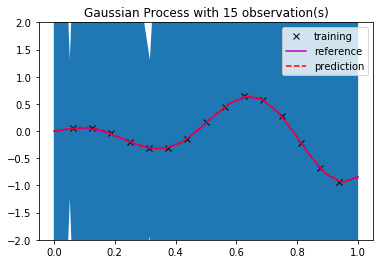

In [20]:
plt.plot(xtrain, ytrain, 'kx')
plt.plot(xtest, ftest, 'm-')
plt.plot(xtest, fmean, 'r--')
axes = plt.gca()
axes.set_ylim([-2, 2])
plt.title('Gaussian Process with '+ str(ntrain) + ' observation(s)')
plt.legend(('training', 'reference', 'prediction'))



plt.fill_between(xtest, # x
                 (fmean.flatten() + 2 * np.sqrt(wld_marginal_variance.flatten())), # y1
                 (fmean.flatten() - 2 * np.sqrt(wld_marginal_variance.flatten()))) # y2


In [37]:

# Step 1 : invert the res.hess_inv to get H_tilde
H_tilde = invert(hess_inv)
# Step 2 Get H
H = np.zeros((len(H_tilde), len(H_tilde)))
for i in np.arange(len(H_tilde)):
    for j in np.arange(len(H_tilde)):
        H[i,j] = (1/np.log(10)**2) * H_tilde[i,j]/(new_hyp[i]*new_hyp[j])
# Step 3 get Sigma
H_inv = invert(H)
sigma_m = H_inv


######################### Build needed Kernel Matrix #########################

# Kernel K(train, train) of shape (ntrain, ntrain)
K = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        K[i, j] = k(xtrain[i], xtrain[j], new_hyp[0])

# Kernel K_star(test, train) of shape (ntest, ntrain)
# note that K_star(test, train) = K_star.T(train, test)
K_star = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        K_star[i, j] = k(xtest[i], xtrain[j], new_hyp[0])


# Derivative of kernel K
K_prime = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        K_prime[i, j] = dkdl(xtrain[i], xtrain[j], new_hyp[0])

# Derivative of kernel K_star
K_star_prime = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        K_star_prime[i, j] = dkdl(xtest[i], xtrain[j], new_hyp[0])

K_2star_prime = np.empty((ntest, ntest))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtest)):
        K_2star_prime[i, j] = dkdl(xtest[i], xtest[j], new_hyp[0])
############################################################################



dKyinv_dl = -Kyinv.dot(K_prime).dot(Kyinv) # Compute the Kyinv's derivative w.r.t. lengthscale

dKyinv_ds = -Kyinv.dot(np.eye(ntrain)).dot(Kyinv) # Compute the Kyinv's derivative w.r.t. sigma noise
                                                              # square
dKyinv = np.concatenate([dKyinv_dl[None,:,:], dKyinv_ds[None,:,:]], axis=0)
print("dKyinv shape : ", dKyinv.shape)


term2_up = K_star.dot(dKyinv_dl).dot(K_star.T)
term2_down = K_star.dot(dKyinv_ds).dot(K_star.T)
term2 = np.concatenate([term2_up [None,:,:], term2_down[None,:,:]], axis=0)


term1 = K_star_prime.dot(Kyinv).dot(K_star.T) 

term3 = K_star.dot(Kyinv).dot(K_star_prime.T)

print("term1 ", term1.shape)
print("term2 ", term2.shape)
print("term3 ", term3.shape)

tot = term1 + term2 + term3
print("tot ", tot.shape)


dKyinv shape :  (2, 15, 15)
term1  (20, 20)
term2  (2, 20, 20)
term3  (20, 20)
tot  (2, 20, 20)


In [22]:
nl = 50
ns2 = 40


log10s2 = np.linspace(res.x[1]-1, res.x[1]+4, ns2)
[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nll([10**log_l, 10**ls2], xtrain, ytrain, 0) for ls2 in log10s2]
    ).reshape([ns2, 1])
    
# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL with fixed lengthscale')
plt.plot(res.x[0], res.x[1], 'rx')
plt.plot(log10s2, nlls)
plt.xlabel('log10 s^^')
plt.ylabel('nll')
plt.legend(['optimum'])
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'x'

In [23]:
nl = 50
ns2 = 40

log10l = np.linspace(res.x[0]-1, res.x[0]+1, nl)

[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nll([10**ll, log_s2], xtrain, ytrain, 0) for ll in log10l]
    ).reshape([nl, 1])
    
# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL')

plt.plot(res.x[0], res.x[1], 'rx')
plt.plot(log10l, nlls)
plt.xlabel('log10 l^2')
plt.ylabel('nll')
plt.legend(['optimum'])
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'x'

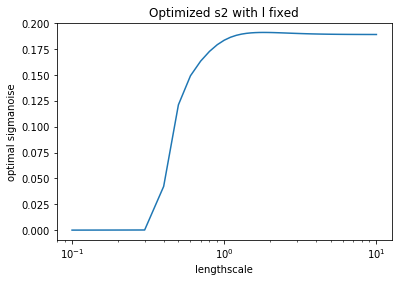

In [28]:

def nll_fixed_l(new_s2, new_l): 
    return nll([new_l, new_s2], xtrain, ytrain, 0)

lengthscale = np.linspace(0.1,10,100)
sigma_noise = []

for i in lengthscale:
    opti = minimize(nll_fixed_l,1e-8, args=(i), method='BFGS')
    sigma_noise.append(opti.x.item())

plt.figure()
plt.title('Optimized s2 with l fixed')
plt.semilogx(lengthscale, sigma_noise)
plt.xlabel('lengthscale')
plt.ylabel('optimal sigmanoise')
plt.savefig('fixed_l')
plt.show()

In [29]:
nll(new_hyp,xtrain, ytrain, 0)

-33.19243446725801